In [31]:
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score
import sklearn.preprocessing as preprocessing
import lightgbm as lgb
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [32]:
train = pd.read_csv('train_set.csv')
test = pd.read_csv('test_set.csv')
data = pd.concat([train, test])

In [33]:
feature = train.columns.tolist()
feature.remove('ID')
feature.remove('y')
object_columns = train.columns[train.dtypes == 'object'].tolist()
num_columns = list(set(feature) - set(object_columns))
print (object_columns)
print (num_columns)

['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'poutcome']
['duration', 'pdays', 'balance', 'day', 'age', 'previous', 'campaign']


In [34]:
train[num_columns].describe()

,duration,pdays,balance,day,age,previous,campaign
count,25317.000000,25317.000000,25317.000000,25317.000000,25317.000000,25317.000000,25317.000000
mean,257.732393,40.248766,1357.555082,15.835289,40.935379,0.591737,2.772050
std,256.975151,100.213541,2999.822811,8.319480,10.634289,2.568313,3.136097
min,0.000000,-1.000000,-8019.000000,1.000000,18.000000,0.000000,1.000000
25%,103.000000,-1.000000,73.000000,8.000000,33.000000,0.000000,1.000000
50%,181.000000,-1.000000,448.000000,16.000000,39.000000,0.000000,2.000000
75%,317.000000,-1.000000,1435.000000,21.000000,48.000000,0.000000,3.000000
max,3881.000000,854.000000,102127.000000,31.000000,95.000000,275.000000,55.000000


In [35]:
data["month"] = data["month"].map({"jan": 1, "feb": 2, 'mar': 3, 'apr': 4, 
                                   'may': 5, 'jun': 6, 'jul': 7, 'aug': 8,
                                   'sep': 9, 'oct': 10, 'nov': 11, 'dec': 12})
data['quater_of_year'] = data['month'].apply(lambda x : x//4)  # 季度
data['quater_of_month'] = data['day'].apply(lambda x : x//7)  # 周
data['balance_positive'] = data['balance'].apply(lambda x : 0 if x < 0 else 1) # 是否有存款
data['month_mul_day'] = data['month'] * 30 + data['day']
data['age_mod_30'] = data['age'].apply(lambda x : x//30)

In [36]:
def feature_count(data, features):
    feature_name = 'count'
    for i in features:
        feature_name += '_' + i
    temp = data.groupby(features).size().reset_index().rename(columns={0: feature_name})
    data = data.merge(temp, 'left', on=features)
    return data,feature_name

In [37]:
# 日期交叉统计特征
date_columns = ['campaign'] + ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'poutcome']
for f in date_columns:
    data, _ = feature_count(data, ['day','month', f])

In [38]:
def get_new_columns(name, aggs):
    l = []
    for k in aggs.keys():
        for agg in aggs[k]:
            if str(type(agg)) == "<class 'function'>":
                l.append(name + '_' + k + '_' + 'other')
            else:
                l.append(name + '_' + k + '_' + agg)
    return l

In [9]:
# for feature in object_columns:
#     print("feature:{}".format(feature))
#     print(data[feature].value_counts())

In [39]:
# 客户的统计特征
# 分组统计f_a的f_b 数值，并作为新特征
f_a = ['job', 'marital', 'education']
f_b = ['balance', 'duration']

aggs = {}
for b in f_b:
    aggs[b] = ['mean','max','min','std']
    
for a in f_a:
    for b in f_b:
        tmp = data.groupby(a, as_index=False).agg(aggs)
        tmp.columns = [a] + get_new_columns(a, aggs)
        data = pd.merge(data, tmp, on=a, how='left')

In [42]:
le = preprocessing.LabelEncoder()
for label in ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'poutcome']:
    le.fit(data[label])
    data[label] = le.transform(data[label])

In [43]:
X_train = data[data['y'].notnull()]
Y_train = X_train['y']
X_test = data[data['y'].isnull()]

X_train.drop(['ID', 'y'], axis=1, inplace=True)
X_test.drop(['y'], axis=1, inplace=True)

feature_names = X_train.columns.tolist()
# categorical_feature加哪些？测出来的
categorical_feature = object_columns + ['quater_of_month', 'age_mod_30']
categorical_feature

['job',
 'marital',
 'education',
 'default',
 'housing',
 'loan',
 'contact',
 'month',
 'poutcome',
 'quater_of_month',
 'age_mod_30']

In [44]:
# 划分数据集 验证集
param = {'num_leaves': 31,
         'min_data_in_leaf': 30, 
         'objective':'binary',
         'max_depth': -1,
         'learning_rate': 0.01,
         "min_child_samples": 20,
         "boosting": "gbdt",
         "feature_fraction": 0.9,
         "bagging_freq": 1,
         "bagging_fraction": 0.9 ,
         "bagging_seed": 11,
         "metric": 'auc',
         "lambda_l1": 0.1,
         "verbosity": -1,
         "nthread": 12,
         "random_state": 42
}

all_preds = []
# all_auc = []
# feature_names = useful_feature
folds = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
splits = folds.split(X_train[feature_names], Y_train)

x_train = X_train[feature_names].values
y_train = Y_train.values

train_pred = np.zeros(len(x_train))
feature_importance_df = pd.DataFrame()

for i, (train_idx, val_idx) in enumerate(splits):
    train_data = lgb.Dataset(data = x_train[train_idx], 
                             label = y_train[train_idx], 
                             feature_name = feature_names, 
                             categorical_feature = categorical_feature)
    val_data = lgb.Dataset(data = x_train[val_idx], 
                           label = y_train[val_idx],
                           feature_name = feature_names, 
                           categorical_feature = categorical_feature, reference = train_data)
    
    num_round = 10000
    clf = lgb.train(param, 
                    train_data, 
                    num_round, 
                    valid_sets = [val_data], 
                    verbose_eval=100,
                    early_stopping_rounds = 100)        
    
    y_pred = clf.predict(data = X_test[feature_names],num_iteration = clf.best_iteration)
    train_pred[val_idx] = clf.predict(data = x_train[val_idx], num_iteration = clf.best_iteration)
#     all_auc.append(clf.best_score['valid_0']['auc'])
    all_preds.append(y_pred)          
    
    fold_importance_df = pd.DataFrame()
    fold_importance_df["Feature"] = feature_names
    fold_importance_df["importance"] = clf.feature_importance()
    fold_importance_df["fold"] = i + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)

Training until validation scores don't improve for 100 rounds.
[100]	valid_0's auc: 0.936094
[200]	valid_0's auc: 0.938379
[300]	valid_0's auc: 0.939353
[400]	valid_0's auc: 0.940538
[500]	valid_0's auc: 0.941117
[600]	valid_0's auc: 0.941672
[700]	valid_0's auc: 0.941799
[800]	valid_0's auc: 0.941817
Early stopping, best iteration is:
[767]	valid_0's auc: 0.942028
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's auc: 0.945073
[200]	valid_0's auc: 0.947756
[300]	valid_0's auc: 0.948143
[400]	valid_0's auc: 0.949383
[500]	valid_0's auc: 0.949826
[600]	valid_0's auc: 0.950095
[700]	valid_0's auc: 0.950172
[800]	valid_0's auc: 0.949911
Early stopping, best iteration is:
[701]	valid_0's auc: 0.950208
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's auc: 0.946822
[200]	valid_0's auc: 0.9479
[300]	valid_0's auc: 0.948989
[400]	valid_0's auc: 0.949799
[500]	valid_0's auc: 0.950341
[600]	valid_0's auc: 0.950781
[700]	valid_0's auc: 0.

In [46]:
roc_auc_score(y_train, train_pred)

0.9415428240533024

In [47]:
y_pred = np.mean(all_preds, axis=0)

In [49]:
submissons = pd.DataFrame({'ID': X_test['ID'], 'pred': y_pred})
submissons.to_csv('submissons.csv', index=False)

In [50]:
submissons.head()

,ID,pred
25317,25318,0.035928
25318,25319,0.003244
25319,25320,0.007789
25320,25321,0.708188
25321,25322,0.023458


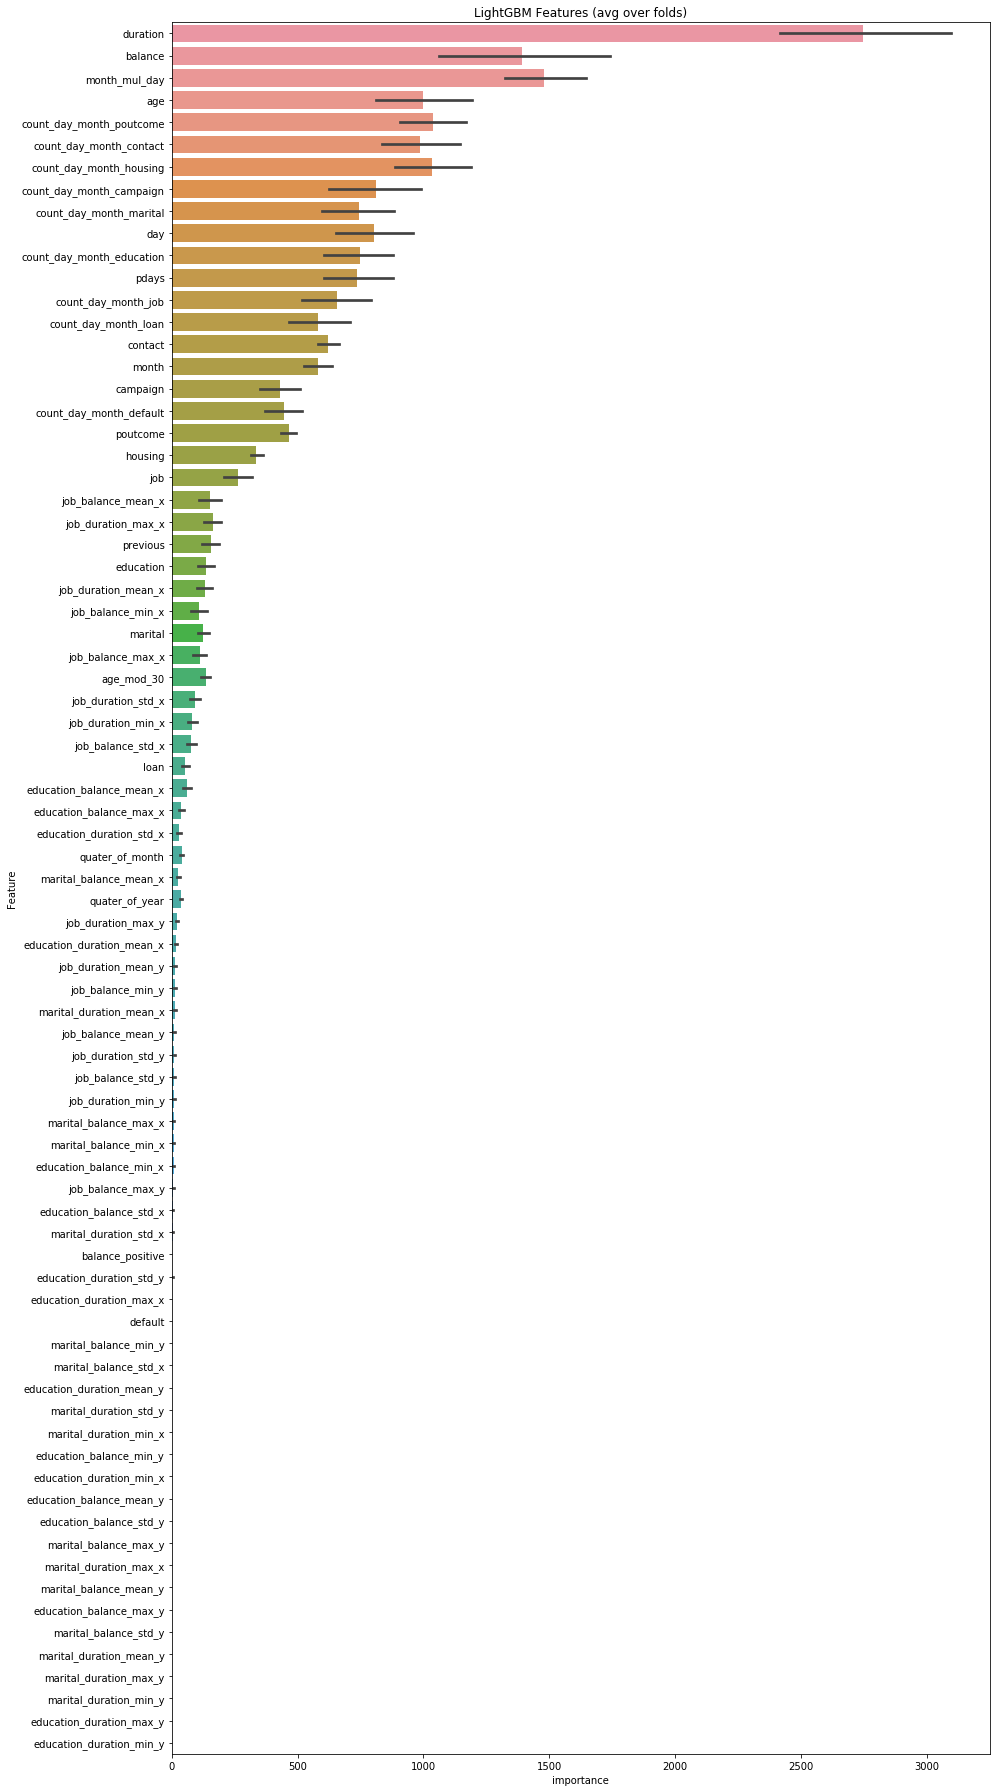

In [51]:
cols = (feature_importance_df[["Feature", "importance"]]
        .groupby("Feature")
        .mean()
        .sort_values(by="importance", ascending=False)[:200].index)

best_features = feature_importance_df.loc[feature_importance_df.Feature.isin(cols)]

plt.figure(figsize=(14,25))
sns.barplot(x = "importance",
            y = "Feature",
            data = best_features.sort_values(by="importance", ascending=False))
plt.title('LightGBM Features (avg over folds)')
plt.tight_layout()